In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


df = pd.read_csv("ASOS_Daily_2000_2004.csv")
print(df.isna().sum())

df = df[["tm", "avgTa", "maxTa", "sumRn", "avgWs", "avgRhm"]]
# index to datetime index
df["ds"] = pd.to_datetime(df["tm"])

# the data is not complete
# features of data is str format
# so we have to change the data type
# first, we need to fill the missing data
df = df.applymap(lambda x: 0 if x == "" else x)
df = df.astype({"avgTa": np.float32, "maxTa": np.float32, "sumRn": np.float32, "avgWs": np.float32, "avgRhm": np.float32})

# manipulate the dataframe
# change columns ("avgTa", "maxTa", "sumRn", "avgWs", "avgRhm") to ("unique_id", "value")
# unique_id is the name of the column
# value is the value of the column

df = df.melt(id_vars = ["ds"], value_vars = ["avgTa", "maxTa", "sumRn", "avgWs", "avgRhm"], var_name = "unique_id", value_name = "y")
df.fillna(0, inplace = True)


Unnamed: 0       0
stnId            0
stnNm            0
tm               0
avgTa            0
              ... 
sumLrgEv       731
sumSmlEv         2
n99Rn         1114
iscs           439
sumFogDur     1773
Length: 63, dtype: int64


In [3]:
df2 = df[df["unique_id"] == "sumRn"]
df2

,ds,unique_id,y
3654,2000-01-01,sumRn,0.0
3655,2000-01-02,sumRn,6.0
3656,2000-01-03,sumRn,0.0
3657,2000-01-04,sumRn,0.0
3658,2000-01-05,sumRn,18.4
...,...,...,...
5476,2004-12-27,sumRn,0.0
5477,2004-12-28,sumRn,0.0
5478,2004-12-29,sumRn,0.0
5479,2004-12-30,sumRn,0.0


In [4]:
# check nan values of df.y
print(df.isna().sum())

ds           0
unique_id    0
y            0
dtype: int64


In [5]:
train = df.loc[df["ds"] < "2004-11-01"]
valid = df.loc[(df['ds'] >= '2004-11-01') & (df['ds'] < '2004-12-31')]
h = valid['ds'].nunique()


In [7]:
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

models = [XGBRegressor(random_state=0, n_estimators=100)]
model = MLForecast(
    models=models,
    freq='D',
    lags=[1,7,14],
    lag_transforms={
        1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],},
    date_features=['dayofweek', 'month'],
    num_threads=6

)


In [8]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
p = model.predict(horizon=h)
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

mean_absolute_percentage_error is : 1.3427087e+16
mean_squared_error is : 53.3584
mean_absolute_error is : 5.2245216
r2_score is : -1.379367945246679


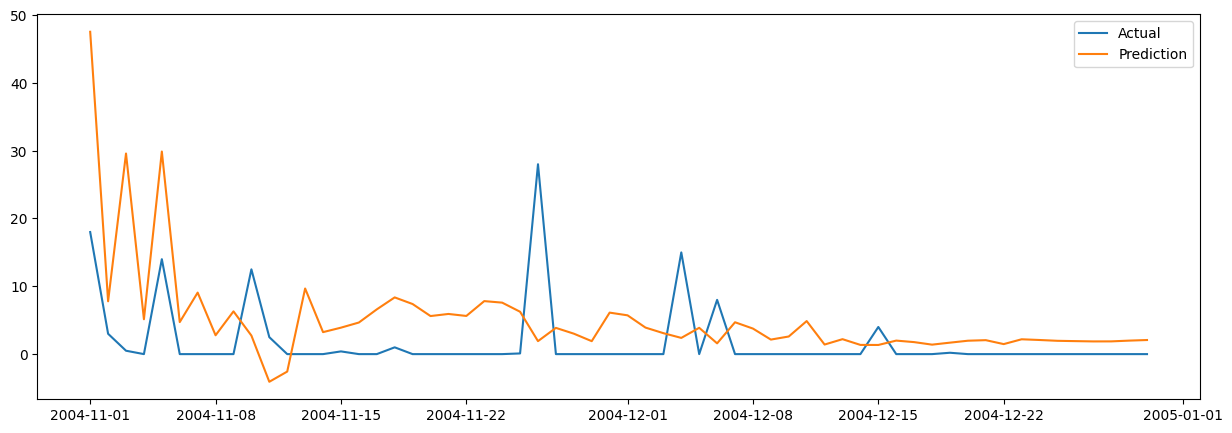

In [9]:
# plot the Actual vs Prediction graph
fig, ax = plt.subplots(figsize=(15, 5))

sumRn = p.loc[p["unique_id"] == "sumRn"]
sumRn = sumRn[sumRn["ds"] >= "2004-01-01"]

ax.plot(sumRn["ds"], sumRn["y"], label = "Actual")
ax.plot(sumRn["ds"], sumRn["XGBRegressor"], label = "Prediction")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
print("mean_absolute_percentage_error is :" , mean_absolute_percentage_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
print("mean_squared_error is :" , mean_squared_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
print("mean_absolute_error is :" , mean_absolute_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
print("r2_score is :" , r2_score(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))

mean_absolute_percentage_error is : 3961378300000000.0
mean_squared_error is : 21.65774
mean_absolute_error is : 2.197058
r2_score is : 0.03423404815223907


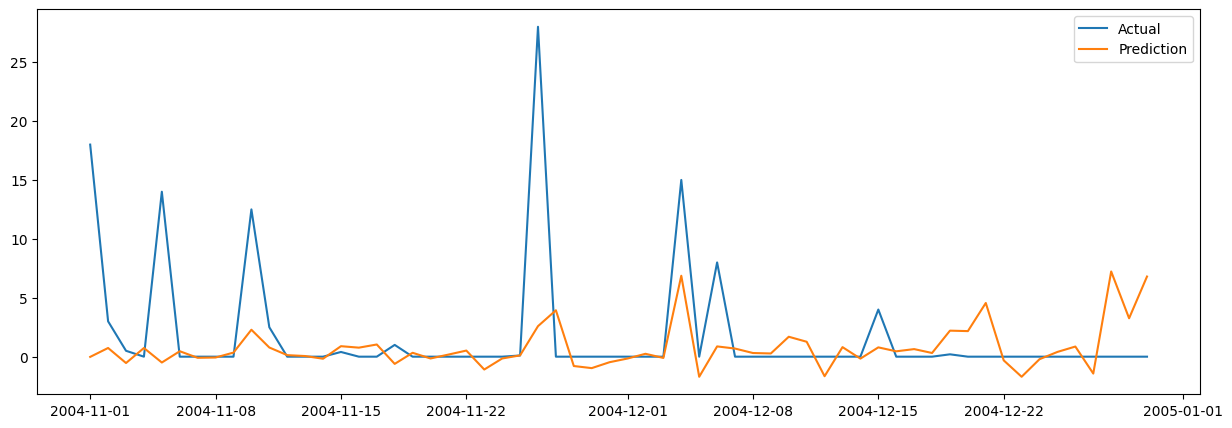

In [10]:
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

train = df2.loc[df2["ds"] < "2004-11-01"]
valid = df2.loc[(df2['ds'] >= '2004-11-01') & (df2['ds'] < '2004-12-31')]

# train = df.loc[df["ds"] < "2004-11-01"]
# valid = df.loc[(df['ds'] >= '2004-11-01') & (df['ds'] < '2004-12-31')]
h = valid['ds'].nunique()


models = [XGBRegressor(random_state=0, n_estimators=100)]
model = MLForecast(
    models=models,
    freq='D',
    lags=[1,7,14],
    lag_transforms={
        1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],},
    date_features=['dayofweek', 'month'],
    num_threads=6

)
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
p = model.predict(horizon=h)
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

# plot the Actual vs Prediction graph
fig, ax = plt.subplots(figsize=(15, 5))

sumRn = p.loc[p["unique_id"] == "sumRn"]
sumRn = sumRn[sumRn["ds"] >= "2004-01-01"]

ax.plot(sumRn["ds"], sumRn["y"], label = "Actual")
ax.plot(sumRn["ds"], sumRn["XGBRegressor"], label = "Prediction")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
print("mean_absolute_percentage_error is :" , mean_absolute_percentage_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
print("mean_squared_error is :" , mean_squared_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
print("mean_absolute_error is :" , mean_absolute_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
print("r2_score is :" , r2_score(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))


In [11]:
p

,unique_id,ds,XGBRegressor,y
0,sumRn,2004-11-01,-0.017320,18.0
1,sumRn,2004-11-02,0.737970,3.0
2,sumRn,2004-11-03,-0.538716,0.5
3,sumRn,2004-11-04,0.736372,0.0
4,sumRn,2004-11-05,-0.495630,14.0
5,sumRn,2004-11-06,0.462290,0.0
6,sumRn,2004-11-07,-0.096134,0.0
7,sumRn,2004-11-08,-0.070801,0.0
8,sumRn,2004-11-09,0.347730,0.0
9,sumRn,2004-11-10,2.286637,12.5


In [60]:
train = df.loc[df["ds"] < "2003-12-31"]
valid = df.loc[(df['ds'] >= '2004-01-01') & (df['ds'] < '2004-12-31')]
h = valid['ds'].nunique()

train


,ds,unique_id,y
0,2000-01-01,avgTa,5.500000
1,2000-01-02,avgTa,4.200000
2,2000-01-03,avgTa,-2.200000
3,2000-01-04,avgTa,0.300000
4,2000-01-05,avgTa,2.800000
...,...,...,...
8763,2003-12-26,avgRhm,44.900002
8764,2003-12-27,avgRhm,45.900002
8765,2003-12-28,avgRhm,60.000000
8766,2003-12-29,avgRhm,66.800003


In [61]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    
    lags = trial.suggest_int('lags', 14, 56, step=7) # step means we only try multiples of 7 starting from 14

    models = [XGBRegressor(random_state=0, n_estimators=100,    learning_rate=learning_rate, max_depth=max_depth,
                           min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,7, lags],
                    lag_transforms={
                       1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                   }, # removing this is better
                    date_features=['dayofweek', 'month'],
                    num_threads=6)


    model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

    p = model.predict(horizon=h)
    p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')
    p = p.loc[p["unique_id"] == "sumRn"]
    error = r2_score(p['y'][1:], p['XGBRegressor'][1:])
    
    return error

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2023-07-14 16:09:06,377] A new study created in memory with name: no-name-c4adc395-b526-421f-bb1e-1534058d6b65
[I 2023-07-14 16:09:09,313] Trial 0 finished with value: -0.05722862418767649 and parameters: {'learning_rate': 0.009351020089722557, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.33858985785305706, 'colsample_bytree': 0.859847602216913, 'lags': 42}. Best is trial 0 with value: -0.05722862418767649.
[I 2023-07-14 16:09:12,269] Trial 1 finished with value: -0.06389893676363734 and parameters: {'learning_rate': 0.00741088738789427, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.17687777841232094, 'colsample_bytree': 0.38472403472493577, 'lags': 14}. Best is trial 0 with value: -0.05722862418767649.
[I 2023-07-14 16:09:15,031] Trial 2 finished with value: -0.10709397879359583 and parameters: {'learning_rate': 0.02029566551736219, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7298979279396213, 'colsample_bytree': 0.3365125383734414, 'lags': 21}. Best is t

KeyboardInterrupt: 

In [54]:
optuna.create_study?

Signature:
optuna.create_study(
    *,
    storage: Union[str, optuna.storages._base.BaseStorage, NoneType] = None,
    sampler: Optional[ForwardRef('samplers.BaseSampler')] = None,
    pruner: Optional[optuna.pruners._base.BasePruner] = None,
    study_name: Optional[str] = None,
    direction: Union[str, optuna.study._study_direction.StudyDirection, NoneType] = None,
    load_if_exists: bool = False,
    directions: Optional[Sequence[Union[str, optuna.study._study_direction.StudyDirection]]] = None,
) -> optuna.study.study.Study
Docstring:
Create a new :class:`~optuna.study.Study`.

Example:

    .. testcode::

        import optuna


        def objective(trial):
            x = trial.suggest_float("x", 0, 10)
            return x**2


        study = optuna.create_study()
        study.optimize(objective, n_trials=3)

Args:
    storage:
        Database URL. If this argument is set to None, in-memory storage is used, and the
        :class:`~optuna.study.Study` will not be persiste

In [ ]:
?

In [51]:
train

,ds,unique_id,y
3654,2000-01-01,sumRn,0.0
3655,2000-01-02,sumRn,6.0
3656,2000-01-03,sumRn,0.0
3657,2000-01-04,sumRn,0.0
3658,2000-01-05,sumRn,18.4
...,...,...,...
5109,2003-12-26,sumRn,0.0
5110,2003-12-27,sumRn,0.0
5111,2003-12-28,sumRn,0.0
5112,2003-12-29,sumRn,1.0


In [62]:
study.best_params, study.best_value

({'learning_rate': 0.014908206275619586,
  'max_depth': 3,
  'min_child_weight': 5,
  'subsample': 0.2084740654211225,
  'colsample_bytree': 0.5778562250830894,
  'lags': 49},
 -0.054325476292774955)

In [89]:
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

train = df2.loc[((df2["ds"] >= pd.to_datetime("2000-05-01")) & (df2['ds'] < pd.to_datetime('2000-09-15'))) |
                ((df2["ds"] >= pd.to_datetime("2001-05-01")) & (df2['ds'] < pd.to_datetime('2001-09-15'))) |
                ((df2["ds"] >= pd.to_datetime("2002-05-01")) & (df2['ds'] < pd.to_datetime('2002-09-15'))) |
                ((df2["ds"] >= pd.to_datetime("2003-05-01")) & (df2['ds'] < pd.to_datetime('2003-09-15')))]
valid = df2.loc[(df2['ds'] >= pd.to_datetime('2004-05-01')) & (df2['ds'] < pd.to_datetime('2004-09-15'))]
h = valid['ds'].nunique()


models = [XGBRegressor(learning_rate=0.01,
                     max_depth=3, min_child_weight=5, subsample=0.2, colsample_bytree=0.58, n_estimators=100)]
model = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7,49],
    lag_transforms={1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],},
    date_features=['dayofweek', 'month'],
    num_threads=6

)
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
p = model.predict(horizon=h)
# p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

# # plot the Actual vs Prediction graph
# fig, ax = plt.subplots(figsize=(15, 5))

# sumRn = p.loc[p["unique_id"] == "sumRn"]
# sumRn = sumRn[sumRn["ds"] >= pd.to_datetime("2004-01-01")]

# ax.plot(sumRn["ds"], sumRn["y"], label = "Actual")
# ax.plot(sumRn["ds"], sumRn["XGBRegressor"], label = "Prediction")
# plt.legend()

# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
# print("mean_absolute_percentage_error is :" , mean_absolute_percentage_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
# print("mean_squared_error is :" , mean_squared_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
# print("mean_absolute_error is :" , mean_absolute_error(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
# print("r2_score is :" , r2_score(sumRn['y'][1:], sumRn['XGBRegressor'][1:]))
